In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


Bad key "text.kerning_factor" on line 4 in
C:\Users\Public\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.
C:\Users\Public\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Public\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Public\Anaconda3\lib\site-packages\tensorflo

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
df = read_csv('preprocessed.csv')
df = df.drop(['gh','csky_ghi'], axis = 1)
df

,datetime,tdry,wspd,pres_hpa,rhum,snowd_m,rainfall,consumption
0,2020-01-01 00:00:00,-0.84,1.51,905.63,50.91,0.000000,0.001754,753.583333
1,2020-01-01 04:00:00,-3.22,2.37,905.38,65.06,0.000000,0.000000,771.250000
2,2020-01-01 05:00:00,-4.01,2.29,905.68,72.50,0.000000,0.000000,862.500000
3,2020-01-01 06:00:00,-5.10,2.34,905.90,81.69,0.000000,0.000000,644.951667
4,2020-01-01 07:00:00,-5.58,2.53,906.16,88.32,0.000000,0.000000,646.215000
...,...,...,...,...,...,...,...,...
1445,2020-03-01 20:00:00,2.56,2.56,897.66,98.38,0.000925,0.000216,76.916667
1446,2020-03-01 21:00:00,1.91,2.60,897.35,102.63,0.000925,0.001415,460.083333
1447,2020-03-01 22:00:00,1.78,2.70,897.10,103.84,0.000925,0.005093,357.500000
1448,2020-03-01 23:00:00,1.87,2.85,896.87,103.66,0.000925,0.009540,274.250000


In [4]:
# load dataset
dataset = read_csv('preprocessed.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[1,2]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  var8(t-1)  \
1    0.00000   0.126615   0.673716   0.250632        0.0   0.000517   
2    0.00000   0.200689   0.667568   0.429474        0.0   0.000000   
3    0.00000   0.193798   0.674944   0.523509        0.0   0.000000   
4    0.00000   0.198105   0.680355   0.639661        0.0   0.000000   
5    0.05954   0.214470   0.686747   0.723458        0.0   0.000000   

   var9(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1   0.845139  0.000000  0.000000  0.268032  0.200689  0.667568  0.429474   
2   0.866518  0.000000  0.000000  0.234315  0.193798  0.674944  0.523509   
3   0.976943  0.000000  0.000000  0.187793  0.198105  0.680355  0.639661   
4   0.713679  0.059540  0.065181  0.167307  0.214470  0.686747  0.723458   
5   0.715208  0.265641  0.274826  0.254375  0.292851  0.697075  0.647118   

   var7(t)  var8(t)   var9(t)  
1      0.0      0.0  0.866518  
2      0.0      0.0  0.976943  
3      0.0      0.0 

In [5]:
# split into train and test sets
values = reframed.values
n_train_hours = 45*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1080, 1, 15) (1080,) (369, 1, 15) (369,)



Train on 1080 samples, validate on 369 samples
Epoch 1/50
 - 0s - loss: 0.2304 - val_loss: 0.1535
Epoch 2/50
 - 0s - loss: 0.1507 - val_loss: 0.1236
Epoch 3/50
 - 0s - loss: 0.1345 - val_loss: 0.1222
Epoch 4/50
 - 0s - loss: 0.1284 - val_loss: 0.1238
Epoch 5/50
 - 0s - loss: 0.1296 - val_loss: 0.1220
Epoch 6/50
 - 0s - loss: 0.1284 - val_loss: 0.1199
Epoch 7/50
 - 0s - loss: 0.1271 - val_loss: 0.1183
Epoch 8/50
 - 0s - loss: 0.1259 - val_loss: 0.1174
Epoch 9/50
 - 0s - loss: 0.1250 - val_loss: 0.1167
Epoch 10/50
 - 0s - loss: 0.1245 - val_loss: 0.1155
Epoch 11/50
 - 0s - loss: 0.1238 - val_loss: 0.1146
Epoch 12/50
 - 0s - loss: 0.1234 - val_loss: 0.1136
Epoch 13/50
 - 0s - loss: 0.1227 - val_loss: 0.1129
Epoch 14/50
 - 0s - loss: 0.1223 - val_loss: 0.1121
Epoch 15/50
 - 0s - loss: 0.1220 - val_loss: 0.1111
Epoch 16/50
 - 0s - loss: 0.1215 - val_loss: 0.1105
Epoch 17/50
 - 0s - loss: 0.1213 - val_loss: 0.1098
Epoch 18/50
 - 0s - loss: 0.1209 - val_loss: 0.1092
Epoch 19/50
 - 0s - loss:

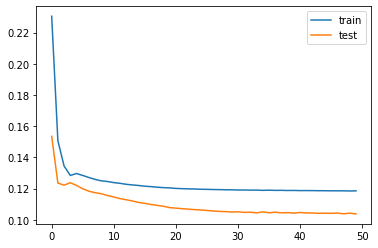

In [6]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
# make a prediction
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 106.691


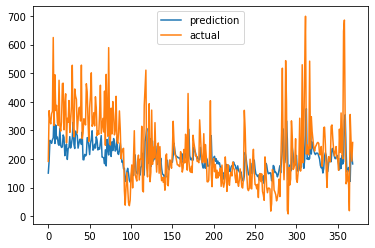

In [30]:
pyplot.plot(inv_yhat, label='prediction')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()